# CS3244 Project Neural Networks

This file will contain the code for the neural network model that is being used for our project. In this code, we will be approaching it using a two types of models:

1. MLP
2. RNN (LSTM)

We will follow this breakdown of sequencing in how we approach the problem using neural networks.

## Importing datasets and packages

We will begin with importing all relevant datasets and packages needed in order to create our model.

### Importing packages

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.init as init
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler
import optuna
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing datasets

#### MLP datasets

In [4]:
fold1 = pd.read_csv('finalised_datasets/smote_train_data/fold_1.csv')
fold2 = pd.read_csv('finalised_datasets/smote_train_data/fold_2.csv')
fold3 = pd.read_csv('finalised_datasets/smote_train_data/fold_3.csv')
fold4 = pd.read_csv('finalised_datasets/smote_train_data/fold_4.csv')
fold5 = pd.read_csv('finalised_datasets/smote_train_data/fold_5.csv')

smote_fold_1 = pd.read_csv('finalised_datasets/smote_train_data/smote_fold_1.csv')
smote_fold_2 = pd.read_csv('finalised_datasets/smote_train_data/smote_fold_2.csv')
smote_fold_3 = pd.read_csv('finalised_datasets/smote_train_data/smote_fold_3.csv')
smote_fold_4 = pd.read_csv('finalised_datasets/smote_train_data/smote_fold_4.csv')
smote_fold_5 = pd.read_csv('finalised_datasets/smote_train_data/smote_fold_5.csv')

In [7]:
test_df = pd.read_csv('finalised_datasets/transformed_data/test_set.csv')

X_test = test_df.drop(columns=['fraud_status'])
y_test = test_df['fraud_status']

#### RNN datasets

In [6]:
# Full data
invoice = pd.read_csv('finalised_datasets/cleaned_data/cleaned_invoice_train.csv')
client = pd.read_csv('finalised_datasets/cleaned_data/cleaned_client_train.csv')

# Competition output data
invoice_output = pd.read_csv('finalised_datasets/cleaned_data/cleaned_invoice_test.csv')
client_output = pd.read_csv('finalised_datasets/cleaned_data/cleaned_client_test.csv')

## MLP model

The MLP model is a simple feed-forward neural network model. It will use the universally used aggregated dataset that we have used for all other models. We have decided to use an MLP model as it is the best neural network model when it comes to working with our aggregated dataset. This is because RNNs work with sequential data, which the aggregated dataset does not have, and CNN works best for matrix data (images), which again we do not have.

We will proceed with this flow:
1. Feature engineering for MLP
2. Model MLP
3. Evaluate MLP

### Feature Engineering for MLP

We will begin with feature engineering that is specific to the MLP model. This is because neural networks require specific altercations to the data for it to function effectively.

In [8]:
X_smoted_1 = smote_fold_1.drop(columns='fraud_status')
y_smoted_1 = smote_fold_1['fraud_status']
X_smoted_2 = smote_fold_2.drop(columns='fraud_status')
y_smoted_2 = smote_fold_2['fraud_status']
X_smoted_3 = smote_fold_3.drop(columns='fraud_status')
y_smoted_3 = smote_fold_3['fraud_status']
X_smoted_4 = smote_fold_4.drop(columns='fraud_status')
y_smoted_4 = smote_fold_4['fraud_status']
X_smoted_5 = smote_fold_5.drop(columns='fraud_status')
y_smoted_5 = smote_fold_5['fraud_status']
smoted_folds = [(X_smoted_1, y_smoted_1), (X_smoted_2, y_smoted_2), (X_smoted_3, y_smoted_3), (X_smoted_4, y_smoted_4), (X_smoted_5, y_smoted_5)]

X_fold_1 = fold1.drop(columns='fraud_status')
y_fold_1 = fold1['fraud_status']
X_fold_2 = fold2.drop(columns='fraud_status')
y_fold_2 = fold2['fraud_status']
X_fold_3 = fold3.drop(columns='fraud_status')
y_fold_3 = fold3['fraud_status']
X_fold_4 = fold4.drop(columns='fraud_status')
y_fold_4 = fold4['fraud_status']
X_fold_5 = fold5.drop(columns='fraud_status')
y_fold_5 = fold5['fraud_status']
folds = [(X_fold_1, y_fold_1), (X_fold_2, y_fold_2), (X_fold_3, y_fold_3), (X_fold_4, y_fold_4), (X_fold_5, y_fold_5)]

In [9]:
scaler = StandardScaler()

# Fit the scaler on the entire training data (folds[0][0])
scaler.fit(folds[0][0])

# Modify the sample_fold function to scale the input data
def sample_fold(X, y, sample_fraction=0.1):
    sample_size = int(len(X) * sample_fraction)
    sample_indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample = scaler.transform(X.iloc[sample_indices])  # Scale X_sample
    return pd.DataFrame(X_sample, columns=X.columns), y.iloc[sample_indices]

# Take 50% samples of each original and SMOTEd fold (and apply scaling)
sampled_folds = [sample_fold(X, y) for X, y in folds]
sampled_smoted_folds = [sample_fold(X, y) for X, y in smoted_folds]

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

def objective(trial):
    hidden_layer_sizes_options = ['100_50', '50', '100', '100_100_50']
    hidden_layer_sizes_str = trial.suggest_categorical('hidden_layer_sizes', hidden_layer_sizes_options)
    hidden_layer_sizes = tuple(map(int, hidden_layer_sizes_str.split('_')))
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)  # Added alpha for L2 regularization

    # Initialize the MLPClassifier with the current hyperparameters
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        learning_rate_init=learning_rate_init,
        max_iter=1000,  # Set a high value for max_iter
        alpha=alpha,
        early_stopping=True,  # Enable early stopping
        validation_fraction=0.1,
        random_state=42
    )

    # List to store F1 scores for each fold
    f1_scores = []

    # Perform 5-fold cross-validation
    for i in range(5):
        # Get the non-SMOTEd validation set (sampled)
        X_val, y_val = sampled_folds[i]

        # Combine the other 4 SMOTEd folds to create the training set (sampled)
        X_train = pd.concat([sampled_smoted_folds[j][0] for j in range(5) if j != i], axis=0)
        y_train = pd.concat([sampled_smoted_folds[j][1] for j in range(5) if j != i], axis=0)

        # Train the MLP model on the sampled SMOTEd training set
        mlp.fit(X_train, y_train)

        # Predict on the non-SMOTEd validation set
        y_pred = mlp.predict(X_val)

        # Calculate F1 score and store it
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)

    # Return the mean F1 score across all folds
    return np.mean(f1_scores)

# Use Optuna to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True, n_jobs=-1)

[I 2024-11-30 21:26:56,280] A new study created in memory with name: no-name-a1ce5bf6-4809-4fc8-8718-23a96361d56f
Best trial: 6. Best value: 0.910102:   3%|▎         | 1/30 [04:25<2:08:10, 265.18s/it]

[I 2024-11-30 21:31:21,521] Trial 6 finished with value: 0.9101022441399745 and parameters: {'hidden_layer_sizes': '50', 'activation': 'tanh', 'solver': 'sgd', 'learning_rate_init': 0.0007521678472856041, 'alpha': 1.1303034751119662e-05}. Best is trial 6 with value: 0.9101022441399745.


Best trial: 0. Best value: 0.914405:   7%|▋         | 2/30 [05:55<1:15:52, 162.61s/it]

[I 2024-11-30 21:32:52,328] Trial 0 finished with value: 0.9144051838460239 and parameters: {'hidden_layer_sizes': '50', 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.00013534326001626883, 'alpha': 1.4424078811677292e-05}. Best is trial 0 with value: 0.9144051838460239.


Best trial: 0. Best value: 0.914405:  10%|█         | 3/30 [06:12<43:09, 95.92s/it]   

[I 2024-11-30 21:33:08,871] Trial 5 finished with value: 0.9116317826174039 and parameters: {'hidden_layer_sizes': '100', 'activation': 'logistic', 'solver': 'sgd', 'learning_rate_init': 0.004548057421059331, 'alpha': 0.006102929324898914}. Best is trial 0 with value: 0.9144051838460239.


Best trial: 0. Best value: 0.914405:  13%|█▎        | 4/30 [08:45<51:15, 118.28s/it]

[I 2024-11-30 21:35:41,438] Trial 8 finished with value: 0.9143310211285604 and parameters: {'hidden_layer_sizes': '50', 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.0010828760908503223, 'alpha': 0.00872890523794599}. Best is trial 0 with value: 0.9144051838460239.


Best trial: 4. Best value: 0.916741:  17%|█▋        | 5/30 [09:27<37:51, 90.88s/it] 

[I 2024-11-30 21:36:23,731] Trial 4 finished with value: 0.9167405271676607 and parameters: {'hidden_layer_sizes': '100', 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.00019953790528729157, 'alpha': 2.183626237778898e-05}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  20%|██        | 6/30 [12:20<47:29, 118.73s/it]

[I 2024-11-30 21:39:16,535] Trial 3 finished with value: 0.3956295130710629 and parameters: {'hidden_layer_sizes': '100_100_50', 'activation': 'logistic', 'solver': 'sgd', 'learning_rate_init': 0.0010135021474661566, 'alpha': 0.0015730466126038112}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  23%|██▎       | 7/30 [12:57<35:14, 91.95s/it] 

[I 2024-11-30 21:39:53,344] Trial 2 finished with value: 0.9143328859462783 and parameters: {'hidden_layer_sizes': '100_100_50', 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.0010459810121298948, 'alpha': 0.00015906061887979183}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  27%|██▋       | 8/30 [13:04<23:53, 65.14s/it]

[I 2024-11-30 21:40:01,083] Trial 10 finished with value: 0.9138207048847538 and parameters: {'hidden_layer_sizes': '100', 'activation': 'tanh', 'solver': 'sgd', 'learning_rate_init': 0.0013372666507146043, 'alpha': 1.1735428168217842e-05}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  30%|███       | 9/30 [13:35<19:05, 54.55s/it]

[I 2024-11-30 21:40:32,341] Trial 7 finished with value: 0.91323142750917 and parameters: {'hidden_layer_sizes': '100_100_50', 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.0018099323352968903, 'alpha': 0.001289109846324971}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  33%|███▎      | 10/30 [15:36<24:56, 74.82s/it]

[I 2024-11-30 21:42:32,537] Trial 15 finished with value: 0.9136524866271897 and parameters: {'hidden_layer_sizes': '50', 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.0044174570310143305, 'alpha': 6.702066059653442e-05}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  37%|███▋      | 11/30 [15:52<17:58, 56.77s/it]

[I 2024-11-30 21:42:48,395] Trial 1 finished with value: 0.9144402753148938 and parameters: {'hidden_layer_sizes': '100_100_50', 'activation': 'tanh', 'solver': 'sgd', 'learning_rate_init': 0.002282905424323878, 'alpha': 0.002328146984843629}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  40%|████      | 12/30 [16:23<14:44, 49.12s/it]

[I 2024-11-30 21:43:20,008] Trial 9 finished with value: 0.9152694380295312 and parameters: {'hidden_layer_sizes': '100_100_50', 'activation': 'logistic', 'solver': 'adam', 'learning_rate_init': 0.006207075385521325, 'alpha': 0.0002511238620390322}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  43%|████▎     | 13/30 [16:28<10:08, 35.82s/it]

[I 2024-11-30 21:43:25,214] Trial 13 finished with value: 0.9147324200370491 and parameters: {'hidden_layer_sizes': '50', 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.006718982056411098, 'alpha': 1.1914834182407825e-05}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  47%|████▋     | 14/30 [17:59<13:56, 52.31s/it]

[I 2024-11-30 21:44:55,647] Trial 16 finished with value: 0.9140179202851755 and parameters: {'hidden_layer_sizes': '50', 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.00024679748403994884, 'alpha': 0.0014699847961316718}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  50%|█████     | 15/30 [18:49<12:56, 51.78s/it]

[I 2024-11-30 21:45:46,204] Trial 11 finished with value: 0.9148043794333185 and parameters: {'hidden_layer_sizes': '100_50', 'activation': 'logistic', 'solver': 'adam', 'learning_rate_init': 0.0019764835452693403, 'alpha': 0.00010344172237194732}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  53%|█████▎    | 16/30 [21:55<21:27, 92.00s/it]

[I 2024-11-30 21:48:51,581] Trial 12 finished with value: 0.906951525564266 and parameters: {'hidden_layer_sizes': '50', 'activation': 'logistic', 'solver': 'sgd', 'learning_rate_init': 0.0005248342640090552, 'alpha': 0.0028245576650024803}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  57%|█████▋    | 17/30 [24:18<23:16, 107.41s/it]

[I 2024-11-30 21:51:14,827] Trial 22 finished with value: 0.9118643790228559 and parameters: {'hidden_layer_sizes': '100', 'activation': 'logistic', 'solver': 'adam', 'learning_rate_init': 0.00041277585567767747, 'alpha': 3.9395394819425524e-05}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  60%|██████    | 18/30 [27:28<26:24, 132.08s/it]

[I 2024-11-30 21:54:24,353] Trial 23 finished with value: 0.912223971897243 and parameters: {'hidden_layer_sizes': '100', 'activation': 'logistic', 'solver': 'adam', 'learning_rate_init': 0.00039335263700698375, 'alpha': 0.0005591104623720087}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  63%|██████▎   | 19/30 [27:28<16:57, 92.49s/it] 

[I 2024-11-30 21:54:24,597] Trial 20 finished with value: 0.9105679436369909 and parameters: {'hidden_layer_sizes': '100_50', 'activation': 'logistic', 'solver': 'adam', 'learning_rate_init': 0.00017845946788075961, 'alpha': 4.957362086726894e-05}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  67%|██████▋   | 20/30 [27:30<10:53, 65.30s/it]

[I 2024-11-30 21:54:26,549] Trial 19 finished with value: 0.9125333764048543 and parameters: {'hidden_layer_sizes': '100_50', 'activation': 'logistic', 'solver': 'adam', 'learning_rate_init': 0.0002987399058683469, 'alpha': 4.9688747261759696e-05}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  70%|███████   | 21/30 [27:30<06:52, 45.85s/it]

[I 2024-11-30 21:54:27,059] Trial 14 finished with value: 0.9136756544692576 and parameters: {'hidden_layer_sizes': '100_50', 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.001049407558034335, 'alpha': 0.0023584796020927005}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  73%|███████▎  | 22/30 [29:18<08:34, 64.31s/it]

[I 2024-11-30 21:56:14,424] Trial 17 finished with value: 0.9158570830476964 and parameters: {'hidden_layer_sizes': '100_50', 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.00010049897195945209, 'alpha': 5.4553448720973204e-05}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  77%|███████▋  | 23/30 [34:04<15:15, 130.83s/it]

[I 2024-11-30 22:01:00,409] Trial 18 finished with value: 0.9145666020536962 and parameters: {'hidden_layer_sizes': '100_50', 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.00017297598075868357, 'alpha': 0.0009067068359522112}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 4. Best value: 0.916741:  80%|████████  | 24/30 [34:20<09:38, 96.41s/it] 

[I 2024-11-30 22:01:16,526] Trial 21 finished with value: 0.9116544342754571 and parameters: {'hidden_layer_sizes': '100_50', 'activation': 'logistic', 'solver': 'adam', 'learning_rate_init': 0.0004389428457363222, 'alpha': 5.563402226489949e-05}. Best is trial 4 with value: 0.9167405271676607.


Best trial: 27. Best value: 0.916877:  83%|████████▎ | 25/30 [37:17<10:02, 120.58s/it]

[I 2024-11-30 22:04:13,447] Trial 27 finished with value: 0.9168771104953727 and parameters: {'hidden_layer_sizes': '100_100_50', 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.008035866825788862, 'alpha': 0.0003348201499203202}. Best is trial 27 with value: 0.9168771104953727.


Best trial: 27. Best value: 0.916877:  87%|████████▋ | 26/30 [37:45<06:12, 93.02s/it] 

[I 2024-11-30 22:04:42,214] Trial 28 finished with value: 0.9164033526776094 and parameters: {'hidden_layer_sizes': '100_50', 'activation': 'logistic', 'solver': 'adam', 'learning_rate_init': 0.0029604809122482753, 'alpha': 0.00020622285996817893}. Best is trial 27 with value: 0.9168771104953727.


Best trial: 27. Best value: 0.916877:  90%|█████████ | 27/30 [38:01<03:28, 69.66s/it]

[I 2024-11-30 22:04:57,318] Trial 26 finished with value: 0.9130335424496941 and parameters: {'hidden_layer_sizes': '100_100_50', 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.0095146183072615, 'alpha': 0.0003140922796200884}. Best is trial 27 with value: 0.9168771104953727.


Best trial: 27. Best value: 0.916877:  93%|█████████▎| 28/30 [38:01<01:38, 49.00s/it]

[I 2024-11-30 22:04:58,176] Trial 24 finished with value: 0.9110551458943679 and parameters: {'hidden_layer_sizes': '100_50', 'activation': 'logistic', 'solver': 'adam', 'learning_rate_init': 0.00012790100678820428, 'alpha': 0.0003675400673571145}. Best is trial 27 with value: 0.9168771104953727.


Best trial: 27. Best value: 0.916877:  97%|█████████▋| 29/30 [38:14<00:37, 37.96s/it]

[I 2024-11-30 22:05:10,361] Trial 29 finished with value: 0.9151501337231309 and parameters: {'hidden_layer_sizes': '100', 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.00010321384226645222, 'alpha': 0.0003597785619496541}. Best is trial 27 with value: 0.9168771104953727.


Best trial: 27. Best value: 0.916877: 100%|██████████| 30/30 [38:17<00:00, 76.59s/it]

[I 2024-11-30 22:05:14,048] Trial 25 finished with value: 0.9163960603495642 and parameters: {'hidden_layer_sizes': '100_50', 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.00010146981801967016, 'alpha': 0.00030740700980334785}. Best is trial 27 with value: 0.9168771104953727.


In [14]:
# Get the best parameters from Optuna
best_trial = study.best_trial
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best cross-validation F1-score:", study.best_value)

# Extract hyperparameters from the best trial found by Optuna
hidden_layer_sizes_str = best_params['hidden_layer_sizes']
if '_' in hidden_layer_sizes_str:
    best_hidden_layer_sizes = tuple(map(int, hidden_layer_sizes_str.split('_')))
else:
    best_hidden_layer_sizes = [int(hidden_layer_sizes_str)]

activation_function = best_params['activation']
learning_rate = best_params['learning_rate_init']

Best Hyperparameters: {'hidden_layer_sizes': '100_100_50', 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.008035866825788862, 'alpha': 0.0003348201499203202}
Best cross-validation F1-score: 0.9168771104953727


### Training MLP model

We will train the neural network on our feature engineered train dataset. Our hyperparameters will be kept fixed (for now), and we will be using the scikit-learn inbuilt function. This is because we were having problems with tensorflow and its compatibility with pandas.

In [15]:
# Combine all SMOTEd folds for final training
X_train_final = pd.concat([fold[0] for fold in smoted_folds], axis=0)
y_train_final = pd.concat([fold[1] for fold in smoted_folds], axis=0)

# Ensure that X_train_final is a DataFrame with feature names
X_train_final = pd.DataFrame(X_train_final, columns=folds[0][0].columns)

# Standardize the final training set
scaler_final = StandardScaler()
X_train_final_scaled = scaler_final.fit_transform(X_train_final)

In [16]:
mlp = MLPClassifier(
    hidden_layer_sizes=best_hidden_layer_sizes,
    activation=activation_function,
    solver=best_params['solver'],
    learning_rate_init=learning_rate,
    max_iter=200,
    random_state=42,
    verbose=True,
    early_stopping=True,  # Enable early stopping for final training
    validation_fraction=0.1
)

In [17]:
mlp.fit(X_train_final_scaled, y_train_final)

Iteration 1, loss = 0.17536473
Validation score: 0.935983
Iteration 2, loss = 0.15456643
Validation score: 0.934176
Iteration 3, loss = 0.14759604
Validation score: 0.940866
Iteration 4, loss = 0.14075227
Validation score: 0.942380
Iteration 5, loss = 0.13821278
Validation score: 0.941062
Iteration 6, loss = 0.13355825
Validation score: 0.944089
Iteration 7, loss = 0.12949766
Validation score: 0.944919
Iteration 8, loss = 0.12684938
Validation score: 0.945163
Iteration 9, loss = 0.12363726
Validation score: 0.948826
Iteration 10, loss = 0.12099153
Validation score: 0.948240
Iteration 11, loss = 0.11918848
Validation score: 0.947556
Iteration 12, loss = 0.11489572
Validation score: 0.949314
Iteration 13, loss = 0.11444192
Validation score: 0.949412
Iteration 14, loss = 0.11136169
Validation score: 0.945505
Iteration 15, loss = 0.11001868
Validation score: 0.950632
Iteration 16, loss = 0.10752824
Validation score: 0.950437
Iteration 17, loss = 0.10589742
Validation score: 0.952146
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100, 50),
              learning_rate_init=0.008035866825788862, random_state=42,
              verbose=True)

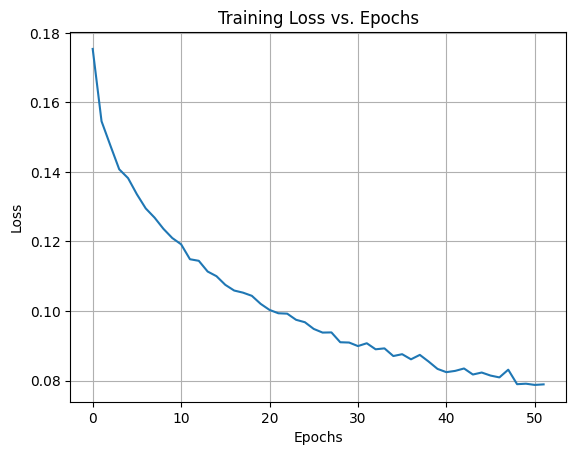

In [21]:
plt.plot(mlp.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid()
plt.show()

### Test MLP model

We will test our model on the feature engineered test dataset. We will be using accuracy, precision, recall, F1 score, as well as a confusion matrix for evaluation.

In [22]:
# Drop irrelevant columns to match the training dataset
irrelevant_columns = ['client_id', 'creation_date', 'meter_number', 'meter_code']
X_test_prepared = X_test.drop(columns=irrelevant_columns, errors='ignore')

# Standardize the test set using the same scaler used for training
X_test_scaled = scaler_final.transform(X_test_prepared)

In [23]:
y_pred = mlp.predict(X_test_scaled)

In [24]:
# Evaluate the model using various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"\nConfusion Matrix:\n{conf_matrix}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"]))

Model Evaluation Metrics:
Accuracy: 0.93
Precision: 0.92
Recall: 0.93
F1 Score: 0.92

Confusion Matrix:
[[24753   782]
 [ 1208   356]]

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.95      0.97      0.96     25535
       Fraud       0.31      0.23      0.26      1564

    accuracy                           0.93     27099
   macro avg       0.63      0.60      0.61     27099
weighted avg       0.92      0.93      0.92     27099



## RNN model

We understand that one of the limitations of the MLP model is that it does not take into account each individual invoice of a client. This results in the loss of some information regarding the sequential nature of the invoices. Hence, for the RNN model, we plan to approach this with a non-aggregated dataset. We will follow the same data cleaning as the previous dataset, but without the aggregation and SMOTE. We will then use an RNN with weight class adjustments in order to deal with the imbalanced data.

We will proceed with this flow:
1. Feature engineering for RNN
2. Preparing data for RNN
3. Model RNN
4. Evaluate RNN


### Feature engineering for RNN

The RNN model uses very different feature engineering techniques compared to the MLP model, and hence we need to handle them very differerntly. We will be looking at client first before invoice.

#### Universal methods

Here, we define some universal methods to make it easier for us to handle the 4 different datasets.

In [4]:
# Method to one hot encode columns in data
def OHE(data, columns):
    data = pd.get_dummies(data, columns=columns)
    return data

# Method to scale columns in data
def scale(data, columns):
    scaler = StandardScaler()
    data[columns] = scaler.fit_transform(data[columns])
    return data

# Method to split specifically creation_date in data
def split_date(data):
    data['creation_date_year'] = data['creation_date'].dt.year
    data['creation_date_month'] = data['creation_date'].dt.month
    data['creation_date_day'] = data['creation_date'].dt.day
    data = data.drop(columns=['creation_date'])
    return data

# Method to convert data into datetime dtype
def datetime(data, columns):
    data[columns] = pd.to_datetime(data[columns])
    return data


#### Client

Here, we will deal with the client dataset. 

##### creation_date breakdown

We breakdown creation_date into year, month, and day in order for our model to be able to process this feature, as it will not be able to process an object or a datetime datatype.

In [5]:
# Convert Creation_date to datetime and split
client = datetime(client, 'creation_date')
client = split_date(client)

client_output = datetime(client_output, 'creation_date')
client_output = split_date(client_output)

##### One hot encoding

We will one hot encode our non ordinal categorical features. This is because we do not want our model to assume ordinality or an order in these features, hence we have to one hot encode.

In [6]:
# List columns to one hot encode
non_ordinal_categorical_client = ['district', 'client_catg', 
                                  'region']

# Apply
client = OHE(client, non_ordinal_categorical_client)
client_output = OHE(client_output, non_ordinal_categorical_client)

##### final client

We will check between the train and output datasets for any differences in their columns due to one hot encoding.

In [7]:
# Get columns as set
df1_columns = set(client.columns)
df2_columns = set(client_output.columns)

# Check difference
missing_in_df1 = df2_columns - df1_columns
missing_in_df2 = df1_columns - df2_columns

# Print
if missing_in_df1 or missing_in_df2:
    print(f"Columns in output but not in train: {missing_in_df1}")
    print(f"Columns in train but not in output: {missing_in_df2}")
else:
    print("The DataFrames have the same columns.")

Columns in output but not in train: set()
Columns in train but not in output: {'fraud_status', 'region_199'}


##### Add differences

As there is a difference, we will add region_199 as a boolean column with all false values. Fraud_status is not an issue as it is our label variable which the output dataset does not need.

In [8]:
# Add difference
client_output['region_199'] = False

##### Check differences

Here, we will check our differences in train and output for clients again.

In [9]:
# Get columns as set
df1_columns = set(client.columns)
df2_columns = set(client_output.columns)

# Check difference
missing_in_df1 = df2_columns - df1_columns
missing_in_df2 = df1_columns - df2_columns

# Print
if missing_in_df1 or missing_in_df2:
    print(f"Columns in output but not in train: {missing_in_df1}")
    print(f"Columns in train but not in output: {missing_in_df2}")
else:
    print("The DataFrames have the same columns.")

Columns in output but not in train: set()
Columns in train but not in output: {'fraud_status'}


#### Invoice

Here, we will deal with the invoice dataset.

##### Deal with invoice_date

We will convert invoice_date to the datetime format for easier processing later down the line, as this will be the determining sequential feature that we will use for the RNN modelling.

In [10]:
# Convert to dateTime
invoice = datetime(invoice, 'invoice_date')

invoice_output = datetime(invoice_output, 'invoice_date')

##### Scaling 

We will scale continuous variables, to ensure that all features contribute equally when it comes to the gradient descent during optimization.

In [11]:
# Set columns to scale
continuous_features_invoice = ['consumption_level_1', 'consumption_level_2',
                       'consumption_level_3', 'consumption_level_4',
                        'diff_in_index', 'old_index', 'months_number']

# Apply
invoice = scale(invoice, continuous_features_invoice)
invoice_output = scale(invoice_output, continuous_features_invoice)

##### One hot encoding

We will similarly one hot encode the non ordinal categorical features in invoice for the same reasons as we did for client.

In [12]:
# Set columns to one hot encode
non_ordinal_categorical_invoice = [ 'meter_status', 'meter_code', 
                            'reading_remark', 'meter_type',
                            'meter_coefficient']

# Apply
invoice = OHE(invoice, non_ordinal_categorical_invoice)
invoice_output = OHE(invoice_output, non_ordinal_categorical_invoice)

##### final invoice

We will check between the train and output datasets for any differences in their columns due to one hot encoding.

In [13]:
# Get columns as set
df1_columns = set(invoice.columns)
df2_columns = set(invoice_output.columns)

# Check difference
missing_in_df1 = df2_columns - df1_columns
missing_in_df2 = df1_columns - df2_columns

# Print
if missing_in_df1 or missing_in_df2:
    print(f"Columns in output but not in train: {missing_in_df1}")
    print(f"Columns in train but not in output: {missing_in_df2}")
else:
    print("The DataFrames have the same columns.")

Columns in output but not in train: set()
Columns in train but not in output: {'meter_coefficient_11', 'meter_coefficient_33', 'meter_coefficient_40', 'meter_coefficient_20', 'meter_coefficient_50', 'meter_code_367', 'meter_coefficient_30'}


##### Add differences

As all the different columns are the one hot encoded variables, we will iteratively add them as boolean columns that are False.

In [14]:
# Add difference
for column in missing_in_df2:
    invoice_output[column] = False

##### Check differences

Here, we will check our differences in train and output for invoice again.

In [15]:
# Get columns as set
df1_columns = set(invoice.columns)
df2_columns = set(invoice_output.columns)

# Check difference
missing_in_df1 = df2_columns - df1_columns
missing_in_df2 = df1_columns - df2_columns

# Print
if missing_in_df1 or missing_in_df2:
    print(f"Columns in output but not in train: {missing_in_df1}")
    print(f"Columns in train but not in output: {missing_in_df2}")
else:
    print("The DataFrames have the same columns.")

The DataFrames have the same columns.


### Preparing data for RNN

In order to prepare our dataset for RNN, we will need to firstly group our invoices by clients, in order of invoice date. We will then be able to extract their informational features. We also need to extract, for the client, their client data, as well as label data (fraud or not fraud). This is so that our RNN is able to use the sequential nature of invoices.

#### Get informational columns

We will obtain the informational features of both invoice and clients, which as the features that we want our model to learn from.

In [16]:
# Invoice feature columns
invoice_feature_cols = invoice.columns.difference(['client_id', 'invoice_date'])

# Client feature columns
client_feature_cols = client.columns.difference(['client_id', 'fraud_status'])

#### Sort the dataset

We will sort our dataset by client_id and invoice_date, followed by grouping invoices by client_id. This helps us obtain the sequences of of invoices that the RNN will input.

In [17]:
# Sort and group 
invoice = invoice.sort_values(by=['client_id', 'invoice_date'])
grouped_invoices = invoice.groupby('client_id')

In [18]:
# Sort and group
invoice_output = invoice_output.sort_values(by=['client_id', 'invoice_date'])
grouped_invoices_output = invoice_output.groupby('client_id')

#### Obtain max_length

We need to obtain the max_length of each group (max number of invoices per client), as only then are we able to apply padding to our sequences to ensure that they are all of the same length. We will use the max between both train and test datasets.

In [19]:
# Get max length
max_length = grouped_invoices.size().max()
max_length1 = grouped_invoices_output.size().max()

# Get max length among both
if max_length < max_length1:
    max_length = max_length1

#### Create containers

We will create 3 containers to store the features and targets, and 2 containers to prepare the test.

In [20]:
invoice_features = []
client_features = []
targets = []

#### iterate each client

For each client, we will select informational invoice features, pad them, and add them to invoice features, then obtain their informational client features and add them to client features, followed by adding their target to the targets container.

In [21]:
# Iterate for each client_id
for client_id, group in grouped_invoices:
    # Get meaningful features
    invoices_seq = group[invoice_feature_cols].values

    # Apply padding
    padded_invoices = np.zeros((max_length, invoices_seq.shape[1]))
    padded_invoices[:len(invoices_seq)] = invoices_seq

    # Add to container
    invoice_features.append(padded_invoices)
    
    # Get meaningful features
    client_row = client[client['client_id'] == client_id].iloc[0]
    client_feat = client_row[client_feature_cols].values
    client_feat = client_feat.astype(int)

    # Add to container
    client_features.append(client_feat)
    
    # Append target
    targets.append(client_row['fraud_status'])

#### Pytorch dataset

We will create a custom pytorch dataset to wrap the data.

In [26]:
class FraudDataset(Dataset):
    def __init__(self, invoice_features, client_features, targets):

        # Invoice features
        self.invoice_features = torch.tensor(invoice_features, dtype=torch.float32)

        # Client features
        self.client_features = torch.tensor(client_features, dtype=torch.float32)

        # Targets
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'invoices': self.invoice_features[idx],
            'clients': self.client_features[idx],
            'target': self.targets[idx]
        }

#### Convert to np.array

We will convert our train and test datasets to np.array for easier use.

In [27]:
# Convert to np.arr
client_features = np.array(client_features, dtype=np.float32)
invoice_features = np.array(invoice_features, dtype=np.float32)
targets = np.array(targets, dtype=np.float32)

#### Train Test Split

We will split the train data into train/test. This is because our test dataset does not have a target, hence cannot be used to test.

In [28]:
# Train test split
invoice_train, invoice_test, client_train, client_test, target_train, target_test = train_test_split(
    invoice_features, client_features, targets, test_size=0.2, random_state=42, stratify=targets
)

#### Create class weights

Due to an imbalance in the classes, we will create class weights based on the proportion of the class distribution.

In [29]:
# Set classes
classes = np.array([0, 1])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=classes, y=target_train)

# Convert to tensor
weights = torch.tensor(class_weights, dtype=torch.float32) 

# Check the shape of weights
print(f"Class weights shape: {weights.shape}")

Class weights shape: torch.Size([2])


#### Weighted random sampler

We will create a weighted random sampler, that will use class weights as a sampling probability. This thus ensures that in each batch that is fed into the model, there is an equal distribution of both classes.

In [30]:
# Change train to int
target_train = target_train.astype(int)

# Assign sample weights based on the target labels
train_weights = torch.tensor([weights[t] for t in target_train], dtype=torch.float32)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(target_train), replacement=True)


#### Input into dataloader

We will load our data into a dataloader to feed into our model.

In [31]:
# Input into dataloader
train_dataset = FraudDataset(invoice_train, client_train, target_train)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

In [32]:
# Input into dataloader
test_dataset = FraudDataset(invoice_test, client_test, target_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

### Create our model

We will create the method of our model. This will be the main method that we will use to run all our code.

#### Create FraudRNN class

We will create the FraudRNN class. To initialize the model, we need to input the parameters listed below:

1. seq_input_dim
2. client_input_dim
3. hidden_dim
4. output_dim
5. num_layers
6. dropout

It will use num_layers number of LSTM layers, as well as a single fully connected layer, and a single output layer.

In [33]:
# Create fraud RNN class
class FraudRNN(nn.Module):
    def __init__(self, seq_input_dim, client_input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super(FraudRNN, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(input_size=seq_input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)

        # FCL
        self.client_dense = nn.Linear(client_input_dim, hidden_dim)

        # Output layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x_seq, x_client):
        _, (h_n, _) = self.lstm(x_seq)
        lstm_out = h_n[-1]
        client_out = torch.relu(self.client_dense(x_client))
        combined = torch.cat((lstm_out, client_out), dim=1)
        output = self.fc(combined)  # Output a single logit per sample
        return output


#### Create xavier initialization

We will also use the xavier initialization in order to have better weights initialization.

In [34]:
# Define Xavier initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):

        # Apply Xavier initialization to Linear layers
        init.xavier_uniform_(m.weight) 
        if m.bias is not None:

            # Initialize bias to zero
            init.zeros_(m.bias) 
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():

            # Input-to-hidden weights
            if 'weight_ih' in name: 
                init.xavier_uniform_(param)
            
            # Hidden-to-hidden weights
            elif 'weight_hh' in name:
                init.orthogonal_(param)
            
            # Orthonormal initialization for recurrent weights
            elif 'bias' in name:
                init.zeros_(param)

### Hyperparameter tuning

We will perform hyperparameter tuning over a subset of hyperparameter values. This will be performed on a 10% sample of our data, as RNN is computationally expensive and our dataset is large. Additionally, we will not be using k-folds cross validation when conducting hyperparameter tuning, again due to computational time. Ideally, given proper set up, we would like to use k-folds cross validation to conduct a gridsearch across a large selection of hyperparameters on the full dataset. 

#### Creating sampled data

Here, we will first set our sample size. We then randomly select indices from the length of our full dataset without replacement. We then proceed to select those indices from our invoice, client and target train. We then assign create a train_weights_sampled, which will be the weights of each item in our sampled dataset. We then create a weighted random sampler for our sampled dataset, and load it with a dataloader.

In [35]:
# 10% of the total dataset size
sample_size = int(0.1 * len(train_dataset)) 

# Random sample
indices = np.random.choice(len(invoice_train), size=sample_size, replace=False)

# Sample all
invoice_sampled = invoice_train[indices]
client_sampled = client_train[indices]
targets_sampled = target_train[indices]

# Assign sample weights based on the target labels
train_weights_sampled = torch.tensor([weights[t] for t in targets_sampled], dtype=torch.float32)

# Create WeightedRandomSampler
sampler_sampled = WeightedRandomSampler(weights=train_weights_sampled, num_samples=sample_size, replacement=True)

# Load to dataloader
sampled_dataset = FraudDataset(invoice_sampled, client_sampled, targets_sampled)
sampled_loader = DataLoader(sampled_dataset, batch_size=16, sampler=sampler_sampled)



#### Set fixed parameters

Here we will set seq_input_dim_sampled and client_input_dim_sampled to be fixed values.

In [38]:
# sample parameters
seq_input_dim_sampled = np.array(invoice_sampled).shape[2]
client_input_dim_sampled = np.array(client_sampled).shape[1]

#### GridSearch across hyperparameter values

We will perform a gridsearch across all combinations of a hyperparameter values to obtain the best parameters and best model results.

In [40]:
import torch
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train and evaluate model
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10):

    # Training loop
    for epoch in range(num_epochs):

        # Train model
        model.train()

        # Set loss
        total_loss = 0

        # Iterate for each batch
        for batch in train_loader:

            # Retrieve info
            X_seq_batch = batch['invoices']
            X_client_batch = batch['clients']
            y_batch = batch['target']

            # Reset optimizer
            optimizer.zero_grad()

            # Get the model's raw logits
            y_pred = model(X_seq_batch, X_client_batch).squeeze()

            # Ensure y_batch is 1D (flatten it)
            y_batch = y_batch.squeeze()

            # Calculate loss
            loss = criterion(y_pred, y_batch)

            # Backpropogation
            loss.backward()

            # Optimizer
            optimizer.step()
            
            # Count loss
            total_loss += loss.item()

    # Evaluate
    model.eval()

    # Set target and predictions
    all_targets = []
    all_predictions = []

    # Evaluate
    with torch.no_grad():

        # Iterate for each batch
        for batch in test_loader:

            # Obtain info
            X_seq_batch = batch['invoices']
            X_client_batch = batch['clients']
            y_batch = batch['target']

            # Get raw logits
            y_pred_logits = model(X_seq_batch, X_client_batch).squeeze()

            # Apply sigmoid to get probabilities
            y_pred_probs = torch.sigmoid(y_pred_logits)

            # Convert probabilities to binary predictions
            y_pred_binary = (y_pred_probs > 0.5).float()

            # Store predictions and true values
            all_predictions.extend(y_pred_binary.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, zero_division=1)
    recall = recall_score(all_targets, all_predictions, zero_division=1)
    f1 = f1_score(all_targets, all_predictions, zero_division=1)

    return accuracy, precision, recall, f1

# Define the hyperparameter grid to search over
param_grid = {

    # Example values for hidden dimension
    'hidden_dim': [32, 64, 128],

    # Example values for LSTM layers
    'num_layers': [1, 2, 3],

    # Example learning rates
    'learning_rate': [0.001, 0.01], 

    # Example dropout values 
    'dropout': [0.3, 0.5]  
}

# Get all combinations of hyperparameters
grid = ParameterGrid(param_grid)

best_score = 0
best_params = {}

# Grid Search Loop
for params in grid:
    print(f"Training with params: {params}")
    
    # Initialize model with current hyperparameters
    model = FraudRNN(seq_input_dim_sampled, client_input_dim_sampled, hidden_dim=params['hidden_dim'], output_dim=1, 
                     num_layers=params['num_layers'], dropout=params['dropout'])
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.BCEWithLogitsLoss()
    
    # Train and evaluate the model
    accuracy, precision, recall, f1 = train_and_evaluate_model(model, sampled_loader, test_loader, optimizer, criterion)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    # Save the best performing model
    if f1 > best_score:
        best_score = f1
        best_params = params

print(f"Best parameters: {best_params}")


Training with params: {'dropout': 0.3, 'hidden_dim': 32, 'learning_rate': 0.001, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Accuracy: 0.0559, Precision: 0.0559, Recall: 1.0000, F1 Score: 0.1058
Training with params: {'dropout': 0.3, 'hidden_dim': 32, 'learning_rate': 0.001, 'num_layers': 2}
Accuracy: 0.3726, Precision: 0.0753, Recall: 0.9075, F1 Score: 0.1391
Training with params: {'dropout': 0.3, 'hidden_dim': 32, 'learning_rate': 0.001, 'num_layers': 3}
Accuracy: 0.5032, Precision: 0.0834, Recall: 0.7905, F1 Score: 0.1509
Training with params: {'dropout': 0.3, 'hidden_dim': 32, 'learning_rate': 0.01, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Accuracy: 0.0590, Precision: 0.0558, Recall: 0.9947, F1 Score: 0.1056
Training with params: {'dropout': 0.3, 'hidden_dim': 32, 'learning_rate': 0.01, 'num_layers': 2}
Accuracy: 0.1294, Precision: 0.0599, Recall: 0.9927, F1 Score: 0.1130
Training with params: {'dropout': 0.3, 'hidden_dim': 32, 'learning_rate': 0.01, 'num_layers': 3}
Accuracy: 0.4270, Precision: 0.0784, Recall: 0.8612, F1 Score: 0.1438
Training with params: {'dropout': 0.3, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Accuracy: 0.3367, Precision: 0.0730, Recall: 0.9299, F1 Score: 0.1354
Training with params: {'dropout': 0.3, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 2}
Accuracy: 0.7478, Precision: 0.1036, Recall: 0.4594, F1 Score: 0.1691
Training with params: {'dropout': 0.3, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 3}
Accuracy: 0.9088, Precision: 0.1493, Recall: 0.1348, F1 Score: 0.1417
Training with params: {'dropout': 0.3, 'hidden_dim': 64, 'learning_rate': 0.01, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Accuracy: 0.9237, Precision: 0.0962, Recall: 0.0436, F1 Score: 0.0600
Training with params: {'dropout': 0.3, 'hidden_dim': 64, 'learning_rate': 0.01, 'num_layers': 2}
Accuracy: 0.1293, Precision: 0.0599, Recall: 0.9927, F1 Score: 0.1130
Training with params: {'dropout': 0.3, 'hidden_dim': 64, 'learning_rate': 0.01, 'num_layers': 3}
Accuracy: 0.9441, Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000
Training with params: {'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Accuracy: 0.0638, Precision: 0.0562, Recall: 0.9987, F1 Score: 0.1065
Training with params: {'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 2}
Accuracy: 0.7100, Precision: 0.1016, Recall: 0.5347, F1 Score: 0.1708
Training with params: {'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 3}
Accuracy: 0.9441, Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000
Training with params: {'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Accuracy: 0.9437, Precision: 0.3103, Recall: 0.0059, F1 Score: 0.0117
Training with params: {'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_layers': 2}
Accuracy: 0.0913, Precision: 0.0576, Recall: 0.9941, F1 Score: 0.1089
Training with params: {'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_layers': 3}
Accuracy: 0.0559, Precision: 0.0559, Recall: 1.0000, F1 Score: 0.1058
Training with params: {'dropout': 0.5, 'hidden_dim': 32, 'learning_rate': 0.001, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Accuracy: 0.6929, Precision: 0.0931, Recall: 0.5142, F1 Score: 0.1576
Training with params: {'dropout': 0.5, 'hidden_dim': 32, 'learning_rate': 0.001, 'num_layers': 2}
Accuracy: 0.7116, Precision: 0.1052, Recall: 0.5545, F1 Score: 0.1768
Training with params: {'dropout': 0.5, 'hidden_dim': 32, 'learning_rate': 0.001, 'num_layers': 3}
Accuracy: 0.1865, Precision: 0.0634, Recall: 0.9855, F1 Score: 0.1192
Training with params: {'dropout': 0.5, 'hidden_dim': 32, 'learning_rate': 0.01, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Accuracy: 0.0589, Precision: 0.0559, Recall: 0.9980, F1 Score: 0.1059
Training with params: {'dropout': 0.5, 'hidden_dim': 32, 'learning_rate': 0.01, 'num_layers': 2}
Accuracy: 0.4026, Precision: 0.0766, Recall: 0.8764, F1 Score: 0.1408
Training with params: {'dropout': 0.5, 'hidden_dim': 32, 'learning_rate': 0.01, 'num_layers': 3}
Accuracy: 0.9438, Precision: 0.2222, Recall: 0.0026, F1 Score: 0.0052
Training with params: {'dropout': 0.5, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Accuracy: 0.9416, Precision: 0.2083, Recall: 0.0165, F1 Score: 0.0306
Training with params: {'dropout': 0.5, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 2}
Accuracy: 0.7234, Precision: 0.1059, Recall: 0.5307, F1 Score: 0.1765
Training with params: {'dropout': 0.5, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_layers': 3}
Accuracy: 0.6978, Precision: 0.1025, Recall: 0.5684, F1 Score: 0.1736
Training with params: {'dropout': 0.5, 'hidden_dim': 64, 'learning_rate': 0.01, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Accuracy: 0.0889, Precision: 0.0575, Recall: 0.9954, F1 Score: 0.1088
Training with params: {'dropout': 0.5, 'hidden_dim': 64, 'learning_rate': 0.01, 'num_layers': 2}
Accuracy: 0.9359, Precision: 0.1056, Recall: 0.0198, F1 Score: 0.0334
Training with params: {'dropout': 0.5, 'hidden_dim': 64, 'learning_rate': 0.01, 'num_layers': 3}
Accuracy: 0.0559, Precision: 0.0559, Recall: 1.0000, F1 Score: 0.1058
Training with params: {'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Accuracy: 0.4517, Precision: 0.0691, Recall: 0.7072, F1 Score: 0.1259
Training with params: {'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 2}
Accuracy: 0.3257, Precision: 0.0719, Recall: 0.9299, F1 Score: 0.1335
Training with params: {'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 3}
Accuracy: 0.9416, Precision: 0.2587, Recall: 0.0245, F1 Score: 0.0447
Training with params: {'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_layers': 1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Accuracy: 0.9431, Precision: 0.2157, Recall: 0.0073, F1 Score: 0.0141
Training with params: {'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_layers': 2}
Accuracy: 0.9439, Precision: 0.1111, Recall: 0.0007, F1 Score: 0.0013
Training with params: {'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_layers': 3}
Accuracy: 0.0559, Precision: 0.0559, Recall: 1.0000, F1 Score: 0.1058
Best parameters: {'dropout': 0.5, 'hidden_dim': 32, 'learning_rate': 0.001, 'num_layers': 2}


### Train and test RNN model

Here, we will start training our best model with the best determined hyperparameters on the full dataset, and obtain evaluation metrics, with and without xavier initialization to compare.

#### Model without xavier initialization

We will train and test the model with the full dataset without xavier initialization.

In [41]:
# Set fixed parameters
seq_input_dim = np.array(invoice_train).shape[2]
client_input_dim = np.array(client_train).shape[1]

# Initialize model
model = FraudRNN(seq_input_dim, client_input_dim, hidden_dim=best_params['hidden_dim'], output_dim=1, 
                 num_layers=best_params['num_layers'], dropout=best_params['dropout'])
    
# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
criterion = nn.BCEWithLogitsLoss()

In [42]:
# Train and get evaluation metrics
accuracy, precision, recall, f1 = train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion)

# Print
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.5314, Precision: 0.0825, Recall: 0.7303, F1 Score: 0.1483


#### Model with xavier initialization

We will train and test the model with the full dataset with xavier initialization.

In [43]:
# Initialize model
model = FraudRNN(seq_input_dim, client_input_dim, hidden_dim=best_params['hidden_dim'], output_dim=1, 
                 num_layers=best_params['num_layers'], dropout=best_params['dropout'])
    
# Initialize optimizer, xavier initalization and loss function
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
criterion = nn.BCEWithLogitsLoss()

In [44]:
# Train and get evaluation metrics
accuracy, precision, recall, f1 = train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion)

# Print
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.6355, Precision: 0.0971, Recall: 0.6662, F1 Score: 0.1696


The model wtih xavier initalization is able to perform better than without!

### Full evaluation of best RNN

In [46]:
# Evaluate
model.eval()

# Set target and predictions
all_targets = []
all_predictions = []

with torch.no_grad():

    # iterate for each batch
    for batch in test_loader:

        # Get info
        X_seq_batch = batch['invoices']
        X_client_batch = batch['clients']
        y_batch = batch['target']

        # Get raw logits
        y_pred_logits = model(X_seq_batch, X_client_batch).squeeze()

        # Apply sigmoid to get probabilities
        y_pred_probs = torch.sigmoid(y_pred_logits)

        # Convert probabilities to binary predictions
        y_pred_binary = (y_pred_probs > 0.5).float()

        # Store predictions and true values
        all_predictions.extend(y_pred_binary.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

In [48]:
# Print full class report
class_report = classification_report(all_targets, all_predictions)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.97      0.63      0.77     25572
         1.0       0.10      0.67      0.17      1513

    accuracy                           0.64     27085
   macro avg       0.53      0.65      0.47     27085
weighted avg       0.92      0.64      0.73     27085



Overall, the evaluation for the RNN model depends on how we weigh misclassifications. 

Looking at the classification report, we see a between 63% to 67%, which indicates that we have around 35% misclassifications for both classes. However, when looking at the precision of fraud, we can see that 90% of predicted positive cases were in fact not fraud. 

This issue with low precision comes from the imbalanced test set. Since we have a large proportion of data from the test set being non-fraud, it potentially polutes the evaluation results.

Overall, we can see that the RNN model performs decently. We will need to compare it to other models to see how it fairs, before determining if it is the best model.